实验报告：
本次实验使用了Python中的matplotlib、numpy、pandas、seaborn和mlxtend库对anonymous MS Web数据集进行了探索性分析和关联规则挖掘。以下是实验步骤和结果：
1. 数据加载和预处理：
   - 使用pandas库读取了两个数据文件"anonymous-msweb.data"，分别命名为attribute_df和user_df，其中attribute_df包含网站属性信息，user_df包含用户访问记录。
   - 从attribute_df中去掉了'marks'和'ignored'两列。
   - 构建了一个ID到名称的映射字典id2name，用于将属性ID转换为属性名称。
   - 对用户访问记录进行处理，将每个用户的访问序列提取出来，并存储在user_df中的'visit'列中。
   - 添加了一个新的列'visit_names'，其中存储了每个用户访问的属性名称。
2. 探索性分析：
   - 统计了每个网站被访问的次数，并将结果存储在record_dict字典中。
   - 绘制了网站访问次数的分布图，分布见上方代码区。
   - 创建了一个包含网站和访问次数的DataFrame hit_df，并对其进行五值描述。
mean       336.686007
std       1156.420373
min          0.000000
25%          9.000000
50%         44.000000
75%        183.000000
max      10836.000000
其中访问次数前十的网站是
title	visits	url
57	Free Downloads	10836.0	/msdownload
283	Internet Explorer	9383.0	/ie
17	Microsoft.com Search	8463.0	/search
287	isapi	5330.0	/isapi
212	Products	5108.0	/products
157	Windows Family of OSs	4628.0	/windows
78	Support Desktop	4451.0	/support
23	Internet Site Construction for Developers	3220.0	/sitebuilder
30	Knowledge Base	2968.0	/kb
122	Web Site Builder's Gallery	2123.0	/gallery
   - 统计了每个网站被访问的次数，并将结果与attribute_df进行合并，添加了'visits'列。
3. 关联规则挖掘：
   - 使用mlxtend库进行关联规则挖掘。
   - 将属性名称转换为二进制编码，构建了一个包含属性编码的DataFrame df。
   - 使用apriori算法挖掘频繁项集，设置最小支持度为0.1。
   - 根据最小支持度生成的频繁项集生成关联规则，并计算支持度、置信度和提升度。
   - 对关联规则进行排序，选择lift值大于1的规则。
4. 实验结果：
   - 频繁项集：
     - 支持度大于0.1的频繁项集共有8个，包括单个网站和网站组合。
    support	itemsets
0	0.331265	(Free Downloads)
1	0.286845	(Internet Explorer)
2	0.258720	(Microsoft.com Search)
3	0.156155	(Products )
4	0.136070	(Support Desktop)
5	0.141481	(Windows Family of OSs)
6	0.162942	(isapi)
7	0.160802	(Internet Explorer, Free Downloads)
   - 关联规则：
     - 通过设置最小支持度为0.0265，（希望至少有 1000 名唯一用户访问过的链接设置规则，支持度约为 1000 / 37711 = 2.65%。所以生成支持度至少为 2.65% 的频繁项集。）挖掘得到了一组关联规则，其中lift值大于1且置信度大于等于0.8的规则有若干条。
    antecedents	consequents	antecedent support	consequent support	support	confidence	lift	leverage	conviction	zhangs_metric
19	(SiteBuilder Network Membership)	(Internet Site Construction for Developers)	0.033934	0.098438	0.027300	0.804505	8.172716	0.023959	4.611677	0.908469
46	(Windows 95)	(Windows Family of OSs)	0.035462	0.141481	0.032436	0.914655	6.464841	0.027418	10.059409	0.876396
53	(Windows95 Support)	(isapi)	0.054752	0.162942	0.046070	0.841429	5.163977	0.037149	5.278770	0.853058
80	(Windows95 Support, Windows Family of OSs)	(isapi)	0.032833	0.162942	0.028737	0.875233	5.371433	0.023387	6.708956	0.841458

以上是本次实验的主要步骤和结果。通过对数据集的探索分析和关联规则挖掘，可以更好地理解用户的访问行为，并发现网站之间的关联关系。
访问过 SiteBuilder Network Membership 的用户也会访问 Internet Site Construction for Developers 站点。
访问 Windows 95 站点的用户也会访问 Windows Family of OS。
此外，访问 Windows95 支持的用户以及一些访问 Windows 系列操作系统的用户也将访问 isapi 站点（Internet Server API）。
从这种模式中，我们了解到数据集包含一组可能是开发人员的用户，并且从他们的网络日志历史记录中，他们可能在阅读一些规范或指南。
优化建议：将这些具有强关联的页面放在同一级导航下，更方便用户访问。


代码如下

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#加载数据
attribute_df = pd.read_csv("anonymous-msweb.data",header=None,skiprows=range(0,7),nrows=293, names=['marks', 'attribute ID','ignored','title','url'])
user_df = pd.read_csv("anonymous-msweb.data",header=None,skiprows=range(0,301), names=['marks', 'ID','ignored'])

In [3]:
#数据预处理
#去掉attribute_df的mark和ignored列
attribute_df.drop(['marks','ignored'],axis=1,inplace=True)
id2name = pd.Series(attribute_df['title'].values,index=attribute_df['attribute ID']).to_dict()

In [4]:
#每个用户的访问序列
user = []
record = []
temp_sequence = None
for index, row in user_df.iterrows():
    if row['marks']=='C':
        if temp_sequence!= None:
            record.append(temp_sequence)
        user.append(row['ID'])
        temp_sequence=[]
    else:
        temp_sequence.append(row['ID'])
record.append(temp_sequence)
user_df = pd.DataFrame({"user":user,"visit":record})
user_df.head(5)

,user,visit
0,10001,"[1000, 1001, 1002]"
1,10002,"[1001, 1003]"
2,10003,"[1001, 1003, 1004]"
3,10004,[1005]
4,10005,[1006]


In [5]:
user_df["visit_names"] = user_df['visit'].apply(lambda x: [id2name[item] for item in x if item in id2name])
user_df.head()

,user,visit,visit_names
0,10001,"[1000, 1001, 1002]","[regwiz, Support Desktop, End User Produced View]"
1,10002,"[1001, 1003]","[Support Desktop, Knowledge Base]"
2,10003,"[1001, 1003, 1004]","[Support Desktop, Knowledge Base, Microsoft.co..."
3,10004,[1005],[Norway]
4,10005,[1006],[misc]


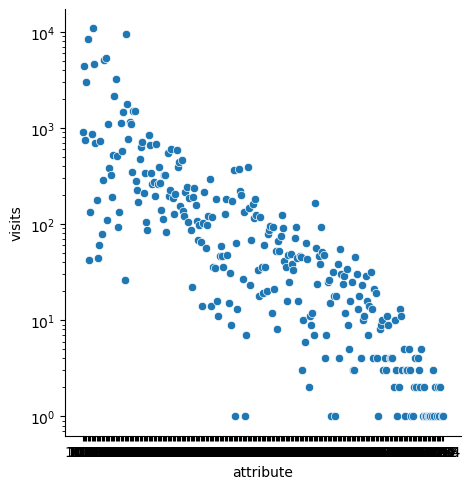

In [9]:
#探索分析
#统计每个网站的访问次数
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
record_dict = {}
for index, row in user_df.iterrows():
    sequence=row['visit']
    for i in sequence:
        if i in record_dict.keys():
            record_dict[i]+=1
        else:
            record_dict[i]=1
attr_list = [i for i in record_dict.keys()]
hit_list = [record_dict[i] for i in attr_list]
hit_df = pd.DataFrame({"attribute":attr_list,"visits":hit_list})
#hit_df.sort_values("visits",inplace=True,ascending=[False])
hit_df['attribute']= hit_df['attribute'].map(lambda x:str(x))
sns.relplot(x="attribute",y="visits",data=hit_df).set(yscale='log')
plt.savefig('test1')

In [10]:
#统计每个网站被访问的次数
hit_df["attribute"] = hit_df["attribute"].map(lambda x:int(x))
attribute_df=pd.merge(attribute_df,hit_df,how='left',left_on="attribute ID",right_on="attribute")
attribute_df.drop(columns="attribute",inplace=True)
attribute_df["visits"] = attribute_df["visits"].fillna(0)
attribute_df["visits"].describe()

count      293.000000
mean       336.686007
std       1156.420373
min          0.000000
25%          9.000000
50%         44.000000
75%        183.000000
max      10836.000000
Name: visits, dtype: float64

In [8]:
#访问次数前十的网站
attribute_df.sort_values("visits",inplace=True,ascending=[False])
attribute_df.head(10)[["title","visits",'url']]

,title,visits,url
57,Free Downloads,10836.0,/msdownload
283,Internet Explorer,9383.0,/ie
17,Microsoft.com Search,8463.0,/search
287,isapi,5330.0,/isapi
212,Products,5108.0,/products
157,Windows Family of OSs,4628.0,/windows
78,Support Desktop,4451.0,/support
23,Internet Site Construction for Developers,3220.0,/sitebuilder
30,Knowledge Base,2968.0,/kb
122,Web Site Builder's Gallery,2123.0,/gallery


In [9]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

te = TransactionEncoder()
encoded_data = te.fit_transform(user_df['visit_names'])
df = pd.DataFrame(encoded_data, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)

In [10]:
#频繁项集
frequent_itemsets

,support,itemsets
0,0.331265,(Free Downloads)
1,0.286845,(Internet Explorer)
2,0.258720,(Microsoft.com Search)
3,0.156155,(Products )
4,0.136070,(Support Desktop)
5,0.141481,(Windows Family of OSs)
6,0.162942,(isapi)
7,0.160802,"(Internet Explorer, Free Downloads)"


In [11]:
# Adjust the min support
#我们希望为一周内至少有 1000 名唯一用户访问过的链接设置规则，支持度约为 1000 / 37711 = 2.65%。所以生成支持度至少为 2.65% 的频繁项集。
min_support = 0.0265
frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
frequent_itemsets.info()
frequent_itemsets.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   support   57 non-null     float64
 1   itemsets  57 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.0+ KB


,support,itemsets
0,0.033230,(Developer Network)
1,0.045856,(Developer Workshop)
2,0.331265,(Free Downloads)
3,0.044205,(Games)
4,0.286845,(Internet Explorer)
5,0.098438,(Internet Site Construction for Developers)
6,0.090734,(Knowledge Base)
7,0.046040,(MS Office Info)
8,0.258720,(Microsoft.com Search)
9,0.156155,(Products )


In [12]:
#接下来生成的规则有其相应的支持度、置信度和提升度。设置Lift值>1。
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values(by=['lift'], ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
82,(Windows95 Support),"(isapi, Windows Family of OSs)",0.054752,0.045000,0.028737,0.524846,11.663215,0.026273,2.009876,0.967218
79,"(isapi, Windows Family of OSs)",(Windows95 Support),0.045000,0.054752,0.028737,0.638587,11.663215,0.026273,2.615422,0.957341
19,(SiteBuilder Network Membership),(Internet Site Construction for Developers),0.033934,0.098438,0.027300,0.804505,8.172716,0.023959,4.611677,0.908469
18,(Internet Site Construction for Developers),(SiteBuilder Network Membership),0.098438,0.033934,0.027300,0.277329,8.172716,0.023959,1.336800,0.973468
47,(Windows Family of OSs),(Windows 95),0.141481,0.035462,0.032436,0.229257,6.464841,0.027418,1.251439,0.984623
46,(Windows 95),(Windows Family of OSs),0.035462,0.141481,0.032436,0.914655,6.464841,0.027418,10.059409,0.876396
0,(Internet Site Construction for Developers),(Developer Workshop),0.098438,0.045856,0.028156,0.286025,6.237439,0.023642,1.336382,0.931359
1,(Developer Workshop),(Internet Site Construction for Developers),0.045856,0.098438,0.028156,0.614000,6.237439,0.023642,2.335653,0.880033
76,(Knowledge Base),"(isapi, Support Desktop)",0.090734,0.059430,0.033230,0.366240,6.162589,0.027838,1.484111,0.921326
73,"(isapi, Support Desktop)",(Knowledge Base),0.059430,0.090734,0.033230,0.559156,6.162589,0.027838,2.062559,0.890662


In [13]:
rules[ (rules['lift'] >= 5) & (rules['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
19,(SiteBuilder Network Membership),(Internet Site Construction for Developers),0.033934,0.098438,0.027300,0.804505,8.172716,0.023959,4.611677,0.908469
46,(Windows 95),(Windows Family of OSs),0.035462,0.141481,0.032436,0.914655,6.464841,0.027418,10.059409,0.876396
53,(Windows95 Support),(isapi),0.054752,0.162942,0.046070,0.841429,5.163977,0.037149,5.278770,0.853058
80,"(Windows95 Support, Windows Family of OSs)",(isapi),0.032833,0.162942,0.028737,0.875233,5.371433,0.023387,6.708956,0.841458


In [ ]:
"""
访问过 SiteBuilder Network Membership 的用户也会访问 Internet Site Construction for Developers 站点。
访问 Windows 95 站点的用户也会访问 Windows Family of OS。
此外，访问 Windows95 支持的用户以及一些访问 Windows 系列操作系统的用户也将访问 isapi 站点（Internet Server API）。
从这种模式中，我们了解到数据集包含一组可能是开发人员的用户，并且从他们的网络日志历史记录中，他们可能在阅读一些规范或指南。
优化建议：将这些具有强关联的页面放在同一级导航下，更方便用户访问。
"""